##### Github Link :  https://github.com/GreatLearningAIML1/gl-pgp-aiml-uta-intl-may20-klbaligala94

#### Objective
Given a Bank customer, build a neural network based classifier that can determine whether they will leave or not in the next 6 months.

#### Context
Businesses like banks which provide service have to worry about problem of 'Churn' i.e. customers leaving and joining another service provider. It is important to understand which aspects of the service influence a customer's decision in this regard. Management can concentrate efforts on improvement of service, keeping in mind these priorities.

In [3]:
%matplotlib inline
#Import Data Processing and Visualization libraries
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

#Modeling and NN libraries
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, precision_recall_curve, auc
from tensorflow.keras import optimizers

#Notebook Output
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [4]:
#Import dataset to Python
bank_ds = pd.read_csv("bank.csv")

In [5]:
#Check on the dataset if imported properly
bank_ds.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


#### Univariate and Bivariate

In [7]:
#Drop the columns which are unique for all users like IDs
#Rownumber , customerid and surnames are not possible predictors since unique for each rows
bank_ds = bank_ds.drop(["RowNumber","CustomerId","Surname"], axis = 1)
bank_ds.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [8]:
#Dataset general information
bank_ds.info()
#Dataset dimension
bank_ds.shape 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CreditScore      10000 non-null  int64  
 1   Geography        10000 non-null  object 
 2   Gender           10000 non-null  object 
 3   Age              10000 non-null  int64  
 4   Tenure           10000 non-null  int64  
 5   Balance          10000 non-null  float64
 6   NumOfProducts    10000 non-null  int64  
 7   HasCrCard        10000 non-null  int64  
 8   IsActiveMember   10000 non-null  int64  
 9   EstimatedSalary  10000 non-null  float64
 10  Exited           10000 non-null  int64  
dtypes: float64(2), int64(7), object(2)
memory usage: 859.5+ KB


(10000, 11)

No nulls for each variable retained in the dataset; Gender and Geography are the categorical variables in this dataset

In [9]:
#Statistical summary metrics for the numeric variables
bank_ds.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
CreditScore,10000.0,650.528800,96.653299,350.00,584.00,652.000,718.0000,850.00
Age,10000.0,38.921800,10.487806,18.00,32.00,37.000,44.0000,92.00
Tenure,10000.0,5.012800,2.892174,0.00,3.00,5.000,7.0000,10.00
Balance,10000.0,76485.889288,62397.405202,0.00,0.00,97198.540,127644.2400,250898.09
NumOfProducts,10000.0,1.530200,0.581654,1.00,1.00,1.000,2.0000,4.00
HasCrCard,10000.0,0.705500,0.455840,0.00,0.00,1.000,1.0000,1.00
IsActiveMember,10000.0,0.515100,0.499797,0.00,0.00,1.000,1.0000,1.00
EstimatedSalary,10000.0,100090.239881,57510.492818,11.58,51002.11,100193.915,149388.2475,199992.48
Exited,10000.0,0.203700,0.402769,0.00,0.00,0.000,0.0000,1.00


By looking at the descriptive statistics, there are no odd values in each of the variable in the dataset. Below, we would identify possible outliers and address them.

In [10]:
#Extract numeric columns from the dataset
columns = list(bank_ds[bank_ds.columns.difference(['Geography', 'Gender'])])
columns

['Age',
 'Balance',
 'CreditScore',
 'EstimatedSalary',
 'Exited',
 'HasCrCard',
 'IsActiveMember',
 'NumOfProducts',
 'Tenure']

In [11]:
#Extract percentiles of each variable
#This will help out identify outliers in the each variable
for column in columns:
    print(column) 
    np.percentile(bank_ds[column], [10,20,30,40,50,60,70,80,90,95,99,100])

Age


array([27., 31., 33., 35., 37., 40., 42., 46., 53., 60., 72., 92.])

Balance


array([     0.    ,      0.    ,      0.    ,  73080.908 ,  97198.54  ,
       110138.926 , 122029.87  , 133710.358 , 149244.792 , 162711.669 ,
       185967.9854, 250898.09  ])

CreditScore


array([521. , 566. , 598.7, 627. , 652. , 678. , 704. , 735. , 778. ,
       812. , 850. , 850. ])

EstimatedSalary


array([ 20273.58  ,  41050.736 ,  60736.079 ,  80238.34  , 100193.915 ,
       119710.038 , 139432.236 , 159836.726 , 179674.704 , 190155.3755,
       198069.7345, 199992.48  ])

Exited


array([0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1.])

HasCrCard


array([0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

IsActiveMember


array([0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1.])

NumOfProducts


array([1., 1., 1., 1., 1., 2., 2., 2., 2., 2., 3., 4.])

Tenure


array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9.,  9., 10., 10.])

<Figure size 432x288 with 0 Axes>

Text(0.5, 1.0, 'Age Boxplot Distribution')

<Figure size 432x288 with 0 Axes>

Text(0.5, 1.0, 'Balance Boxplot Distribution')

<Figure size 432x288 with 0 Axes>

Text(0.5, 1.0, 'CreditScore Boxplot Distribution')

<Figure size 432x288 with 0 Axes>

Text(0.5, 1.0, 'EstimatedSalary Boxplot Distribution')

<Figure size 432x288 with 0 Axes>

Text(0.5, 1.0, 'Exited Boxplot Distribution')

<Figure size 432x288 with 0 Axes>

Text(0.5, 1.0, 'HasCrCard Boxplot Distribution')

<Figure size 432x288 with 0 Axes>

Text(0.5, 1.0, 'IsActiveMember Boxplot Distribution')

<Figure size 432x288 with 0 Axes>

Text(0.5, 1.0, 'NumOfProducts Boxplot Distribution')

<Figure size 432x288 with 0 Axes>

Text(0.5, 1.0, 'Tenure Boxplot Distribution')

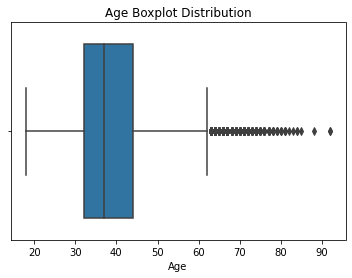

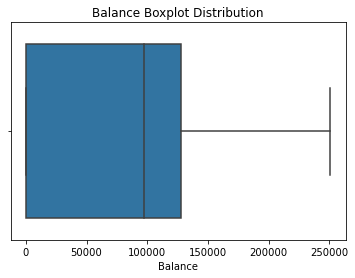

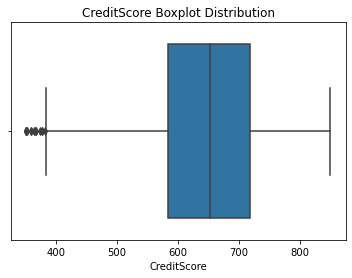

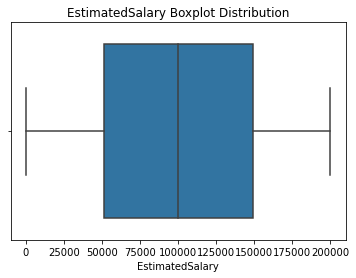

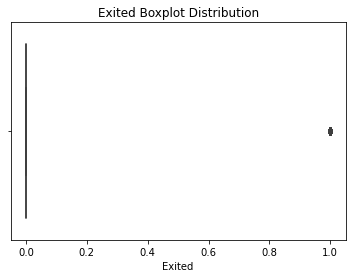

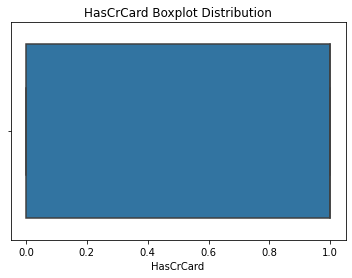

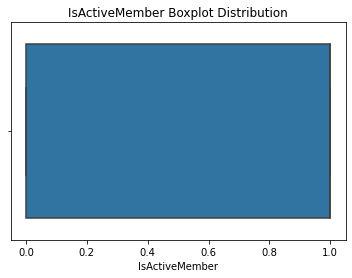

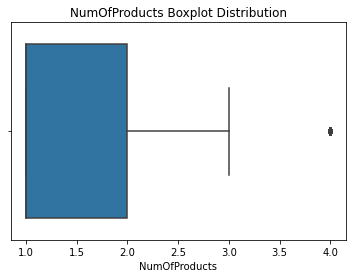

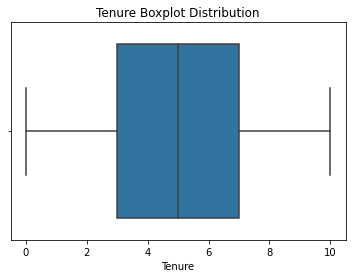

In [12]:
#Distribution and Outlier detection of all numeric variables in the dataset (Boxplot)
for column in columns:
    plt.figure()  
    sns.boxplot(bank_ds[column]).set_title(column + ' Boxplot Distribution')

Since some of these variables have noticeable outliers from the box plot, we capped them into their approximately 99th percentile or 1st percentile for minimum to address these and not delete any observations from our dataset.

In [13]:
#Based on the estimated values near 99th percentile and IQR range, we cap the variable to 75 (45 rows capped)
len(bank_ds[(bank_ds['Age']>75)])
bank_ds.loc[bank_ds.Age > 75, 'Age'] = 75

45

In [14]:
#Based on the estimated values near 1st percentile and IQR range, we cap the min variable to 400 (19 rows capped)
len(bank_ds[(bank_ds['CreditScore']<400)])
bank_ds.loc[bank_ds.CreditScore <400, 'CreditScore'] = 400

19

Text(0.5, 1.0, 'NumOfProducts Frequency Distribution')

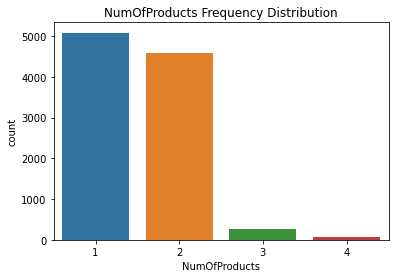

In [15]:
#Additional one way for categorical variables in the dataset to get distribution
sns.countplot(bank_ds['NumOfProducts']).set_title('NumOfProducts Frequency Distribution')

Text(0.5, 1.0, 'Geography Frequency Distribution')

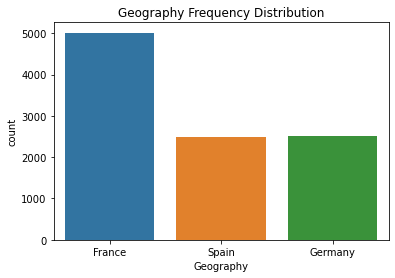

In [16]:
sns.countplot(bank_ds['Geography']).set_title('Geography Frequency Distribution')

Text(0.5, 1.0, 'Gender Frequency Distribution')

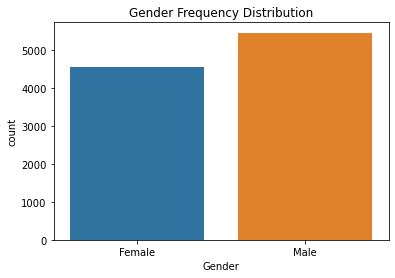

In [17]:
sns.countplot(bank_ds['Gender']).set_title('Gender Frequency Distribution')

<Figure size 720x576 with 0 Axes>

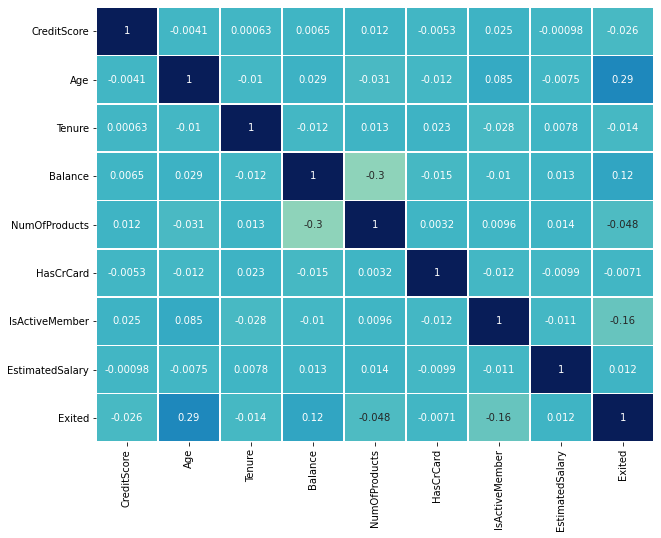

In [18]:
#Bivariate Analysis
#Correlation Plot
plt.figure(figsize=(10,8))
sns.heatmap(bank_ds.corr(),
            annot=True,
            linewidths=.5,
            center=0,
            cbar=False,
            cmap="YlGnBu")

plt.show()

Based on the correlation plot, there are no variables that are strongly correlated with each other. Strongest is variable 'Age' with the Target variable 'Exited' but not enough strength to remove them from the modeling activity.

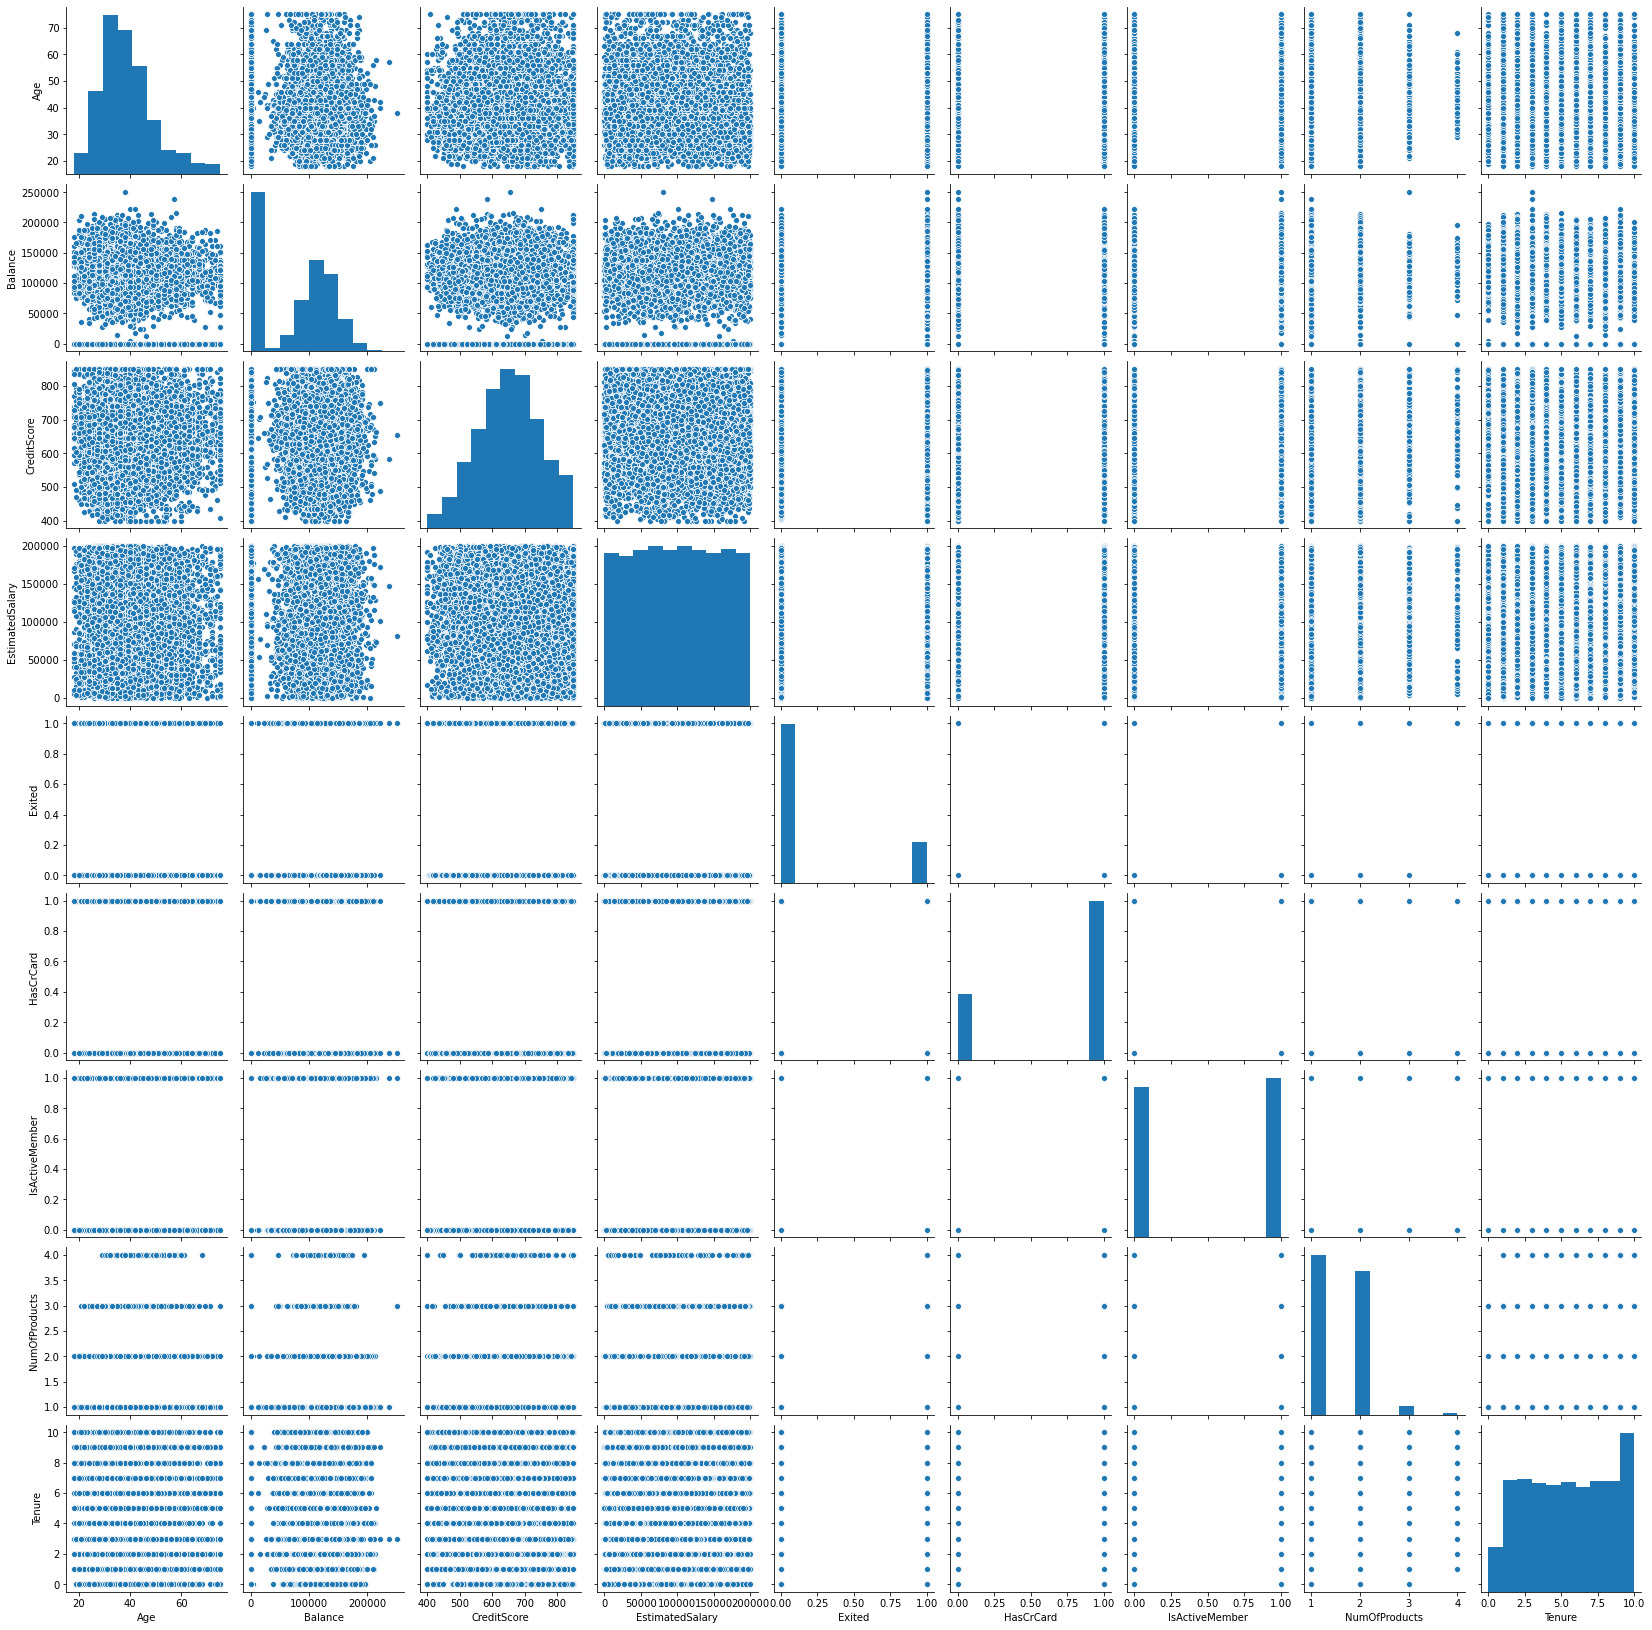

In [19]:
#Additional pairplots for all numeric variables
bank_ds_2 =bank_ds[bank_ds.columns.difference(['Geography', 'Gender'])]
sns.pairplot(bank_ds_2)

Age is seemingly skewed to the right and CreditScore has a most likely normal distribution. Other variables are just flat.

In [20]:
#Change categorical features to indicators
oneHotCols=["Geography","Gender"]

In [21]:
#Produce indicators for different levels of Gender and Geography
bank_ds=pd.get_dummies(bank_ds, columns=oneHotCols)

In [22]:
#Quick view of the latest dataset with indicators
bank_ds.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male
0,619,42,2,0.00,1,1,1,101348.88,1,1,0,0,1,0
1,608,41,1,83807.86,1,0,1,112542.58,0,0,0,1,1,0
2,502,42,8,159660.80,3,1,0,113931.57,1,1,0,0,1,0
3,699,39,1,0.00,2,0,0,93826.63,0,1,0,0,1,0
4,850,43,2,125510.82,1,1,1,79084.10,0,0,0,1,1,0


### Modeling

#### Data Split & Normalization

In [23]:
#For the train data, remove the target variable (Exited) and other variables that are redundant to the dataset
#Removed Gender_Male as there is a Female indicator already in the dataset , same case with Spain as 2 other levels of geog are already present
X_data = bank_ds[bank_ds.columns.difference(['Exited', 'Gender_Male','Geography_Spain'])]
X_data.head()

,Age,Balance,CreditScore,EstimatedSalary,Gender_Female,Geography_France,Geography_Germany,HasCrCard,IsActiveMember,NumOfProducts,Tenure
0,42,0.00,619,101348.88,1,1,0,1,1,1,2
1,41,83807.86,608,112542.58,1,0,0,0,1,1,1
2,42,159660.80,502,113931.57,1,1,0,1,0,3,8
3,39,0.00,699,93826.63,1,1,0,0,0,2,1
4,43,125510.82,850,79084.10,1,0,0,1,1,1,2


In [24]:
X_data.shape

(10000, 11)

In [25]:
#Retain the Y/Target variable which is 'Exited'
y_data = bank_ds.iloc[:, 8]

In [26]:
y_data.head()

0    1
1    0
2    1
3    0
4    0
Name: Exited, dtype: int64

In [27]:
y_data.shape

(10000,)

In [28]:
#Split the dataset into train and test (70% train, 30% test)
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size = 0.30, random_state = 123)

In [29]:
#Dimension of the datasets
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(7000, 11)
(3000, 11)
(7000,)
(3000,)


In [30]:
#Normalize train dataset
X_train = preprocessing.normalize(X_train)

In [31]:
#View normalized version of the train dataset
X_train

array([[2.76468775e-04, 4.09023338e-01, 3.25730484e-03, ...,
        5.02670500e-06, 5.02670500e-06, 5.02670500e-06],
       [4.20650068e-04, 0.00000000e+00, 5.11421925e-03, ...,
        7.37982575e-06, 1.47596515e-05, 6.64184318e-05],
       [1.96122219e-04, 0.00000000e+00, 3.48265517e-03, ...,
        5.94309756e-06, 1.18861951e-05, 4.16016829e-05],
       ...,
       [1.79145350e-04, 9.38004514e-01, 6.13572823e-03, ...,
        0.00000000e+00, 1.79145350e-05, 3.58290699e-05],
       [1.57354795e-04, 4.95372670e-01, 3.37263778e-03, ...,
        5.24515984e-06, 5.24515984e-06, 2.62257992e-05],
       [3.95789307e-03, 0.00000000e+00, 7.75747042e-02, ...,
        0.00000000e+00, 1.13082659e-04, 4.52330637e-04]])

In [32]:
#Normalized test dataset
X_test = preprocessing.normalize(X_test)

In [33]:
#View normalized version of the test dataset
X_test

array([[3.04443027e-04, 0.00000000e+00, 6.97532699e-03, ...,
        8.95420666e-06, 1.79084133e-05, 4.47710333e-05],
       [1.30725216e-04, 3.91070969e-01, 3.76086390e-03, ...,
        5.02789292e-06, 5.02789292e-06, 5.02789292e-06],
       [2.56579695e-04, 7.29080185e-01, 5.96547792e-03, ...,
        9.16356055e-06, 9.16356055e-06, 9.16356055e-05],
       ...,
       [2.80173789e-04, 9.79190658e-01, 4.61150912e-03, ...,
        7.57226457e-06, 7.57226457e-06, 3.78613228e-05],
       [3.50419899e-04, 9.18882340e-01, 5.38450088e-03, ...,
        8.54682679e-06, 8.54682679e-06, 5.98277876e-05],
       [1.58175564e-04, 6.49667428e-01, 3.98075169e-03, ...,
        5.27251879e-06, 1.05450376e-05, 2.10900752e-05]])

#### Initial Model Creation with Prediction and Performance Evaluation

In [34]:
model = Sequential()
model

In [35]:
#adding different activation functions
model.add(Dense(64, input_shape = (11,), activation = 'relu'))
model.add(Dense(1, activation = 'sigmoid'))

In [36]:
#Specify optimizer and learning rate
sgd = optimizers.Adam(lr = 0.0001)

In [37]:
model.compile(optimizer = sgd, loss = 'binary_crossentropy', metrics=['accuracy'])

In [38]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                768       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 833
Trainable params: 833
Non-trainable params: 0
_________________________________________________________________


In [39]:
#Fit the initial model , specify size and epochs
model.fit(X_train, y_train.values, batch_size = 300, epochs = 10, verbose = 1)

Train on 7000 samples
Epoch 1/10
7000/7000 [==============================] - 1s 77us/sample - loss: 0.6930 - accuracy: 0.4530
Epoch 2/10
7000/7000 [==============================] - 0s 5us/sample - loss: 0.6819 - accuracy: 0.7521
Epoch 3/10
7000/7000 [==============================] - 0s 5us/sample - loss: 0.6713 - accuracy: 0.7900
Epoch 4/10
7000/7000 [==============================] - 0s 5us/sample - loss: 0.6612 - accuracy: 0.7947
Epoch 5/10
7000/7000 [==============================] - 0s 5us/sample - loss: 0.6516 - accuracy: 0.7947
Epoch 6/10
7000/7000 [==============================] - 0s 5us/sample - loss: 0.6426 - accuracy: 0.7949
Epoch 7/10
7000/7000 [==============================] - 0s 5us/sample - loss: 0.6340 - accuracy: 0.7950
Epoch 8/10
7000/7000 [==============================] - 0s 4us/sample - loss: 0.6259 - accuracy: 0.7951
Epoch 9/10
7000/7000 [==============================] - 0s 5us/sample - loss: 0.6179 - accuracy: 0.7954
Epoch 10/10
7000/7000 [==================

In [40]:
#Initial model evaluation on test data
results = model.evaluate(X_test, y_test.values)

3000/1 [================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

In [41]:
#Print Metrics of the initial metrics
print(model.metrics_names)
print(results)    

['loss', 'accuracy']
[0.6051157523790995, 0.79833335]


In [42]:
#Predict at default 0.5 threshold. Output accuracy score and confusion matrix
Y_pred_cls = model.predict_classes(X_test, batch_size=300,verbose=1)
print('Accuracy Model1 (Dropout): '+ str(model.evaluate(X_test,y_test.values)[1]))
confusion_matrix(y_test.values, Y_pred_cls)

3000/1 [================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

3000/1 [================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

Accuracy Model1 (Dropout): 0.79833335


array([[2395,    0],
       [ 605,    0]], dtype=int64)

#### Model 2 : With improvements implemented, Predictions and Model Performance Evaluation

In [43]:
model2 = Sequential()

In [44]:
#Same activation functions with different dense value and adding more
model2.add(Dense(255, input_shape = (11,), activation = 'relu'))
model2.add(Dense(255, activation = 'tanh'))
model2.add(Dense(1, activation = 'sigmoid'))

In [45]:
from tensorflow.keras.optimizers import SGD
#Different optimizer with changed learning rate and specified momentum
opt = SGD(lr=0.7, momentum=0.9)
model2.compile(optimizer = opt, loss ='binary_crossentropy', metrics=['accuracy'])
model2.summary()
#Change batch size
model2.fit(X_train, y_train.values, batch_size = 100, epochs = 10, verbose = 1)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 255)               3060      
_________________________________________________________________
dense_3 (Dense)              (None, 255)               65280     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 256       
Total params: 68,596
Trainable params: 68,596
Non-trainable params: 0
_________________________________________________________________
Train on 7000 samples
Epoch 1/10
7000/7000 [==============================] - 0s 64us/sample - loss: 0.5152 - accuracy: 0.7867
Epoch 2/10
7000/7000 [==============================] - 0s 18us/sample - loss: 0.5033 - accuracy: 0.7954
Epoch 3/10
7000/7000 [==============================] - 0s 19us/sample - loss: 0.5063 - accuracy: 0.7954
Epoch 4/10
7000/7000 [=====================

In [46]:
results2 = model2.evaluate(X_test, y_test.values)

3000/1 [================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

In [47]:
print(model2.metrics_names)
print(results2)    

['loss', 'accuracy']
[0.4978062611420949, 0.79833335]


In [48]:
#Predict at default 0.5 threshold. Output accuracy score and confusion matrix
Y_pred_cls2 = model2.predict_classes(X_test, batch_size=100, verbose=1)
print('Accuracy Model2 (Dropout): '+ str(model2.evaluate(X_test,y_test.values)[1]))
confusion_matrix(y_test.values, Y_pred_cls2)

3000/1 [================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

3000/1 [================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

Accuracy Model2 (Dropout): 0.79833335


array([[2395,    0],
       [ 605,    0]], dtype=int64)

Notes:
* Between the initial model and model 2 (with changes and improvements) , the overall accuracy did not improve but the loss error improved in model 2 when we changed some hyperparameters and updated the optimizer, learning rate, size etc.
* Also, the learning time by model 2 is faster achieved at very first few epochs unlike the initial model that takes several batches to have a consistent accuracy.
* Model 2 also performed better in test data with less loss error rate.
* Overall, either the initial model or model 2 could predict the churn rate of the bank by identifying customers who will leave or stay with almost 80% accuracy.
    